In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

file_path = '/content/drive/MyDrive/01_Weather/RO_temp_mean_10d.npy'

In [4]:
data = np.load(file_path)

In [5]:
data.shape

(232, 12, 18, 36)

In [6]:
data=np.add(data, 273.15)

In [7]:
import numpy as np
from scipy.ndimage import generic_filter

def fill_nan_with_local_mean(data, kernel_size=3):
    """
    data: numpy array (232, 12, 18, 36)
    """
    filled = data.copy()

    for n in range(filled.shape[0]):      # samples
        for l in range(filled.shape[1]):  # levels
            grid = filled[n, l]

            nan_mask = np.isnan(grid)
            if not np.any(nan_mask):
                continue

            # local mean filter ignoring NaNs
            def nanmean_filter(values):
                vals = values[~np.isnan(values)]
                return np.mean(vals) if len(vals) > 0 else np.nan

            filtered = generic_filter(
                grid,
                nanmean_filter,
                size=kernel_size,
                mode='nearest'
            )

            grid[nan_mask] = filtered[nan_mask]

            # if still NaN → fill with global mean
            if np.any(np.isnan(grid)):
                global_mean = np.nanmean(grid)
                grid[np.isnan(grid)] = global_mean

            filled[n, l] = grid

    return filled

In [8]:
data_fill=fill_nan_with_local_mean(data)

In [9]:
import numpy as np
X=data
# X shape: (232, 12, 18, 36)
print("Data shape:", X.shape)

# 전체 NaN 개수
total_nan = np.isnan(X).sum()
print("Total NaN count:", total_nan)

# 샘플별 NaN 개수
nan_per_sample = np.isnan(X).sum(axis=(1,2,3))
print("NaN per sample (first 10):", nan_per_sample[:10])

# 레벨별 NaN 개수
nan_per_level = np.isnan(X).sum(axis=(0,2,3))
print("NaN per level:", nan_per_level)

# 공간 위치별 NaN 개수 (전체 시간/레벨 기준)
nan_spatial = np.isnan(X).sum(axis=(0,1))
print("NaN map shape:", nan_spatial.shape)

Data shape: (232, 12, 18, 36)
Total NaN count: 25514
NaN per sample (first 10): [31 31 32 32 30 30 23 23 26 26]
NaN per level: [2540  602  492  504 1902 6986 5052 3598 1644  888  680  626]
NaN map shape: (18, 36)


In [10]:
import numpy as np
X=data_fill
# X shape: (232, 12, 18, 36)
print("Data shape:", X.shape)

# 전체 NaN 개수
total_nan = np.isnan(X).sum()
print("Total NaN count:", total_nan)

# 샘플별 NaN 개수
nan_per_sample = np.isnan(X).sum(axis=(1,2,3))
print("NaN per sample (first 10):", nan_per_sample[:10])

# 레벨별 NaN 개수
nan_per_level = np.isnan(X).sum(axis=(0,2,3))
print("NaN per level:", nan_per_level)

# 공간 위치별 NaN 개수 (전체 시간/레벨 기준)
nan_spatial = np.isnan(X).sum(axis=(0,1))
print("NaN map shape:", nan_spatial.shape)

Data shape: (232, 12, 18, 36)
Total NaN count: 0
NaN per sample (first 10): [0 0 0 0 0 0 0 0 0 0]
NaN per level: [0 0 0 0 0 0 0 0 0 0 0 0]
NaN map shape: (18, 36)


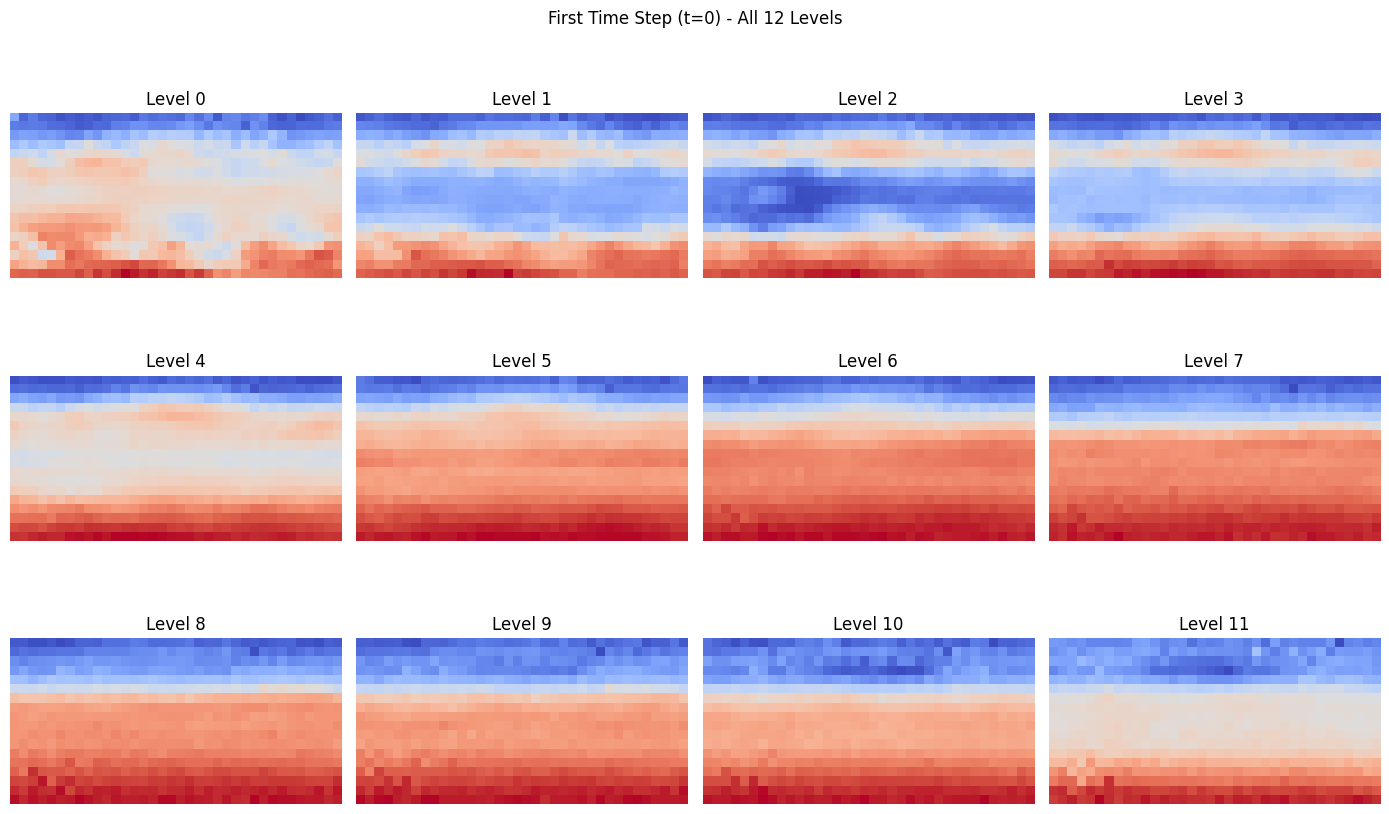

In [11]:
import matplotlib.pyplot as plt

t = 0  # first time step

fig, axes = plt.subplots(3, 4, figsize=(14, 9))
axes = axes.flatten()

for level in range(12):
    ax = axes[level]
    im = ax.imshow(X[t, level], cmap='coolwarm')
    ax.set_title(f"Level {level}")
    ax.axis("off")

#fig.colorbar(im, ax=axes.tolist(), shrink=0.6)
plt.suptitle("First Time Step (t=0) - All 12 Levels")
plt.tight_layout()
plt.show()

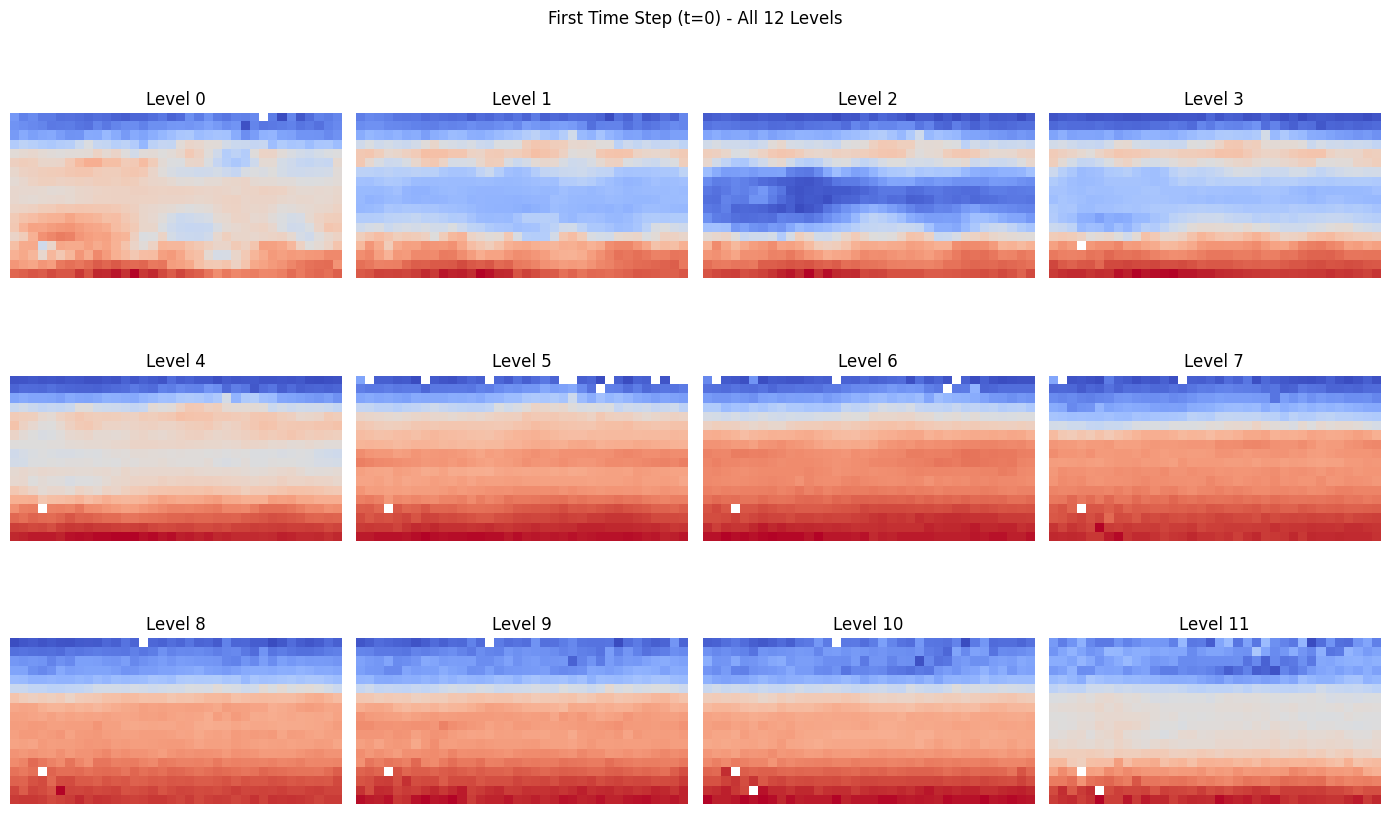

In [12]:
import matplotlib.pyplot as plt

t = 10  # first time step

fig, axes = plt.subplots(3, 4, figsize=(14, 9))
axes = axes.flatten()

for level in range(12):
    ax = axes[level]
    im = ax.imshow(data[t, level], cmap='coolwarm')
    ax.set_title(f"Level {level}")
    ax.axis("off")

#fig.colorbar(im, ax=axes.tolist(), shrink=0.6)
plt.suptitle("First Time Step (t=0) - All 12 Levels")
plt.tight_layout()
plt.show()

In [13]:
X_input = X[:-1]   # t = 0 ~ 230  → shape (231, 12, 18, 36)
X_target = X[1:]   # t = 1 ~ 231  → shape (231, 12, 18, 36)

print("Input shape:", X_input.shape)
print("Target shape:", X_target.shape)

Input shape: (231, 12, 18, 36)
Target shape: (231, 12, 18, 36)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------
# ResNet blocks
# -------------------------
class ResBlock(nn.Module):
    def __init__(self, ch, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, ch, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = out + identity
        out = self.act(out)
        return out


class ResStage(nn.Module):
    """(optional) 채널 변경 + ResBlock 여러 개"""
    def __init__(self, in_ch, out_ch, n_blocks=2, dropout=0.0):
        super().__init__()
        self.proj = None
        if in_ch != out_ch:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.blocks = nn.Sequential(*[ResBlock(out_ch, dropout=dropout) for _ in range(n_blocks)])

    def forward(self, x):
        x = self.conv_in(x)
        x = self.blocks(x)
        return x


# -------------------------
# ResNet-style Encoder–Decoder
# (fully convolutional, same I/O shape)
# -------------------------
class ResNetEncoderDecoder(nn.Module):
    def __init__(self, in_ch=12, base=32, out_ch=12, dropout=0.0):
        super().__init__()
        # Encoder
        self.enc1 = ResStage(in_ch, base,   n_blocks=2, dropout=dropout)      # 18x36
        self.pool1 = nn.MaxPool2d(2, 2)                                       # -> 9x18

        self.enc2 = ResStage(base, base*2, n_blocks=2, dropout=dropout)      # 9x18
        self.pool2 = nn.MaxPool2d(2, 2)                                       # -> 4x9

        self.enc3 = ResStage(base*2, base*4, n_blocks=3, dropout=dropout)    # 4x9
        self.pool3 = nn.MaxPool2d(2, 2)                                       # -> 2x4

        # Bottleneck
        self.bott = ResStage(base*4, base*4, n_blocks=2, dropout=dropout)    # 2x4

        # Decoder (upsample + ResStages)
        self.dec3 = ResStage(base*4, base*2, n_blocks=2, dropout=dropout)    # up to 4x9
        self.dec2 = ResStage(base*2, base,   n_blocks=2, dropout=dropout)    # up to 9x18
        self.dec1 = ResStage(base,   base,   n_blocks=2, dropout=dropout)    # up to 18x36

        # Output head
        self.out = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)           # (N, base, 18,36)
        p1 = self.pool1(x1)         # (N, base, 9,18)

        x2 = self.enc2(p1)          # (N, 2b, 9,18)
        p2 = self.pool2(x2)         # (N, 2b, 4,9)

        x3 = self.enc3(p2)          # (N, 4b, 4,9)
        p3 = self.pool3(x3)         # (N, 4b, 2,4)

        # Bottleneck
        b = self.bott(p3)           # (N, 4b, 2,4)

        # Decoder (same 방식으로 size 맞춤)
        u3 = F.interpolate(b, size=x3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(u3)          # (N, 2b, 4,9)

        u2 = F.interpolate(d3, size=x2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(u2)          # (N, b, 9,18)

        u1 = F.interpolate(d2, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(u1)          # (N, b, 18,36)

        y = self.out(d1)            # (N, out_ch, 18,36)
        return y

In [16]:
# VGG-style Encoder–Decoder for X_t -> X_{t+1}
# Data: X shape = (232, 12, 18, 36)  (time, level, lat, lon)
# Task: input = X[t], target = X[t+1]  => 231 samples
#
# What you get in this script:
# 1) Build (X_in, Y_out) pairs
# 2) Time-aware split: train/val/test (no shuffling across time)
# 3) Dataset + DataLoaders
# 4) VGG-style Encoder–Decoder model (fully convolutional)
# 5) Train + validation + best checkpoint + final test evaluation

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# -------------------------
# 0) Repro / device
# -------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# -------------------------
# 1) Pair construction: (t -> t+1)
# -------------------------
def make_pairs(X):
    """
    X: numpy array, shape (T, C, H, W) = (232, 12, 18, 36)
    returns:
      X_in:  (T-1, C, H, W)
      Y_out: (T-1, C, H, W)
    """
    assert X.ndim == 4, f"Expected 4D (T,C,H,W), got {X.shape}"
    X_in = X[:-1]
    Y_out = X[1:]
    return X_in, Y_out


# -------------------------
# 2) Time-aware split (recommended for forecasting)
# -------------------------
def time_split_indices(n, train_ratio=0.7, val_ratio=0.15):
    """
    n: number of samples (here 231)
    returns: train_idx, val_idx, test_idx as numpy arrays
    """
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_idx = np.arange(0, n_train)
    val_idx = np.arange(n_train, n_train + n_val)
    test_idx = np.arange(n_train + n_val, n_train + n_val + n_test)
    return train_idx, val_idx, test_idx


# -------------------------
# 3) Dataset (+ optional standardization)
# -------------------------
class ForecastDataset(Dataset):
    def __init__(self, X_in, Y_out, idx, standardize=True, stats=None):
        """
        X_in, Y_out: numpy arrays (N, C, H, W)
        idx: indices to select
        standardize:
          - if True and stats is None: compute stats from X_in[idx]
          - if True and stats provided: use given stats (mean,std)
        stats: dict {"mean": (1,C,1,1), "std": (1,C,1,1)} as torch tensors
        """
        self.X = X_in[idx]
        self.Y = Y_out[idx]

        # convert to torch
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float()

        # NaN check (must be filled before training)
        if torch.isnan(self.X).any() or torch.isnan(self.Y).any():
            raise ValueError("NaNs detected in X/Y. Fill NaNs before training.")

        self.standardize = standardize
        if standardize:
            if stats is None:
                # per-channel mean/std over N,H,W
                mean = self.X.mean(dim=(0, 2, 3), keepdim=True)
                std = self.X.std(dim=(0, 2, 3), keepdim=True).clamp_min(1e-6)
                self.stats = {"mean": mean, "std": std}
            else:
                self.stats = stats

            self.X = (self.X - self.stats["mean"]) / self.stats["std"]
            self.Y = (self.Y - self.stats["mean"]) / self.stats["std"]  # predict in standardized space too

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.Y[i]


# -------------------------
# 4) VGG-style Encoder–Decoder model
#    - Encoder: VGG blocks + MaxPool
#    - Decoder: Upsample + VGG blocks
#    - Output: same (C,H,W) as target
# -------------------------
class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_conv=2):
        super().__init__()
        layers = []
        ch = in_ch
        for _ in range(n_conv):
            layers += [
                nn.Conv2d(ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ]
            ch = out_ch
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class VGGEncoderDecoder(nn.Module):
    def __init__(self, in_ch=12, base=32, out_ch=12):
        super().__init__()
        # Encoder (VGG-ish)
        self.enc1 = VGGBlock(in_ch, base, n_conv=2)        # 18x36
        self.pool1 = nn.MaxPool2d(2, 2)                    # -> 9x18

        self.enc2 = VGGBlock(base, base*2, n_conv=2)       # 9x18
        self.pool2 = nn.MaxPool2d(2, 2)                    # -> 4x9

        self.enc3 = VGGBlock(base*2, base*4, n_conv=3)     # 4x9
        self.pool3 = nn.MaxPool2d(2, 2)                    # -> 2x4

        # Bottleneck
        self.bott = VGGBlock(base*4, base*4, n_conv=2)     # 2x4

        # Decoder (upsample to exact encoder feature sizes)
        self.dec3 = VGGBlock(base*4, base*2, n_conv=2)     # up to 4x9
        self.dec2 = VGGBlock(base*2, base, n_conv=2)       # up to 9x18
        self.dec1 = VGGBlock(base, base, n_conv=2)         # up to 18x36

        # Output head
        self.out = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)              # (N, base, 18,36)
        p1 = self.pool1(x1)            # (N, base, 9,18)

        x2 = self.enc2(p1)             # (N, 2b, 9,18)
        p2 = self.pool2(x2)            # (N, 2b, 4,9)

        x3 = self.enc3(p2)             # (N, 4b, 4,9)
        p3 = self.pool3(x3)            # (N, 4b, 2,4)

        # Bottleneck
        b = self.bott(p3)              # (N, 4b, 2,4)

        # Decoder: upsample to match sizes exactly (robust to odd dims)
        u3 = F.interpolate(b, size=x3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(u3)             # (N, 2b, 4,9)

        u2 = F.interpolate(d3, size=x2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(u2)             # (N, b, 9,18)

        u1 = F.interpolate(d2, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(u1)             # (N, b, 18,36)

        y = self.out(d1)               # (N, out_ch, 18,36)
        return y


# -------------------------
# 5) Train / Validate / Test loops
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    for Xb, Yb in loader:
        Xb = Xb.to(device)
        Yb = Yb.to(device)

        pred = model(Xb)
        loss = criterion(pred, Yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total = 0.0
    for Xb, Yb in loader:
        Xb = Xb.to(device)
        Yb = Yb.to(device)

        pred = model(Xb)
        loss = criterion(pred, Yb)
        total += loss.item() * Xb.size(0)
    return total / len(loader.dataset)


def fit_model(
    X,
    batch_size=16,
    epochs=50,
    lr=1e-3,
    train_ratio=0.7,
    val_ratio=0.15,
    weight_decay=1e-4,
    ckpt_path="best_vgg_ed.pt",
):
    # pairs
    X_in, Y_out = make_pairs(X)  # (231,12,18,36)
    n = X_in.shape[0]

    # split indices (time-aware)
    tr_idx, va_idx, te_idx = time_split_indices(n, train_ratio=train_ratio, val_ratio=val_ratio)
    print(f"Samples: total={n}, train={len(tr_idx)}, val={len(va_idx)}, test={len(te_idx)}")

    # datasets (compute stats on train only, reuse)
    train_ds = ForecastDataset(X_in, Y_out, tr_idx, standardize=True, stats=None)
    stats = train_ds.stats
    val_ds = ForecastDataset(X_in, Y_out, va_idx, standardize=True, stats=stats)
    test_ds = ForecastDataset(X_in, Y_out, te_idx, standardize=True, stats=stats)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    # model
    #model = VGGEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)
    model = ResNetEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)

    # loss / optim
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss = eval_one_epoch(model, val_loader, criterion)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            torch.save(best_state, ckpt_path)

        if ep == 1 or ep % 5 == 0:
            print(f"[Epoch {ep:03d}] train MSE={tr_loss:.6f} | val MSE={va_loss:.6f} | best val={best_val:.6f}")

    # load best
    if best_state is None and os.path.exists(ckpt_path):
        best_state = torch.load(ckpt_path, map_location="cpu")
    if best_state is not None:
        model.load_state_dict(best_state)

    # final test
    te_loss = eval_one_epoch(model, test_loader, criterion)
    print(f"Final TEST MSE (standardized space): {te_loss:.6f}")

    return model, stats, (train_loader, val_loader, test_loader)


# -------------------------
# 6) RUN (You must define X)
# -------------------------
# X must be a numpy array: (232,12,18,36) with NaNs already filled.
#
# Example:
# X = np.load("your_data.npy")  # shape (232,12,18,36)
# model, stats, loaders = fit_model(X, epochs=50, batch_size=16, lr=1e-3)

Device: cpu


In [17]:
model, stats, loaders = fit_model(X, epochs=50, batch_size=16, lr=1e-3)

Samples: total=231, train=161, val=34, test=36
[Epoch 001] train MSE=0.677416 | val MSE=0.529148 | best val=0.529148
[Epoch 005] train MSE=0.058595 | val MSE=0.125007 | best val=0.125007
[Epoch 010] train MSE=0.041866 | val MSE=0.128363 | best val=0.112886
[Epoch 015] train MSE=0.035436 | val MSE=0.118270 | best val=0.109813
[Epoch 020] train MSE=0.032211 | val MSE=0.103345 | best val=0.103345
[Epoch 025] train MSE=0.032656 | val MSE=0.111743 | best val=0.094029
[Epoch 030] train MSE=0.030472 | val MSE=0.090914 | best val=0.090914
[Epoch 035] train MSE=0.029237 | val MSE=0.088330 | best val=0.084094
[Epoch 040] train MSE=0.024140 | val MSE=0.079319 | best val=0.079319
[Epoch 045] train MSE=0.027189 | val MSE=0.075000 | best val=0.075000
[Epoch 050] train MSE=0.023191 | val MSE=0.084311 | best val=0.074854
Final TEST MSE (standardized space): 0.113360


InceptionNet

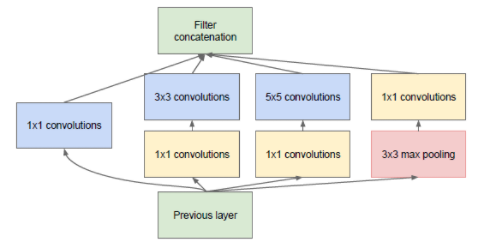

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------
# Inception module (2D)
# -------------------------
class InceptionModule(nn.Module):
    """
    Branches:
      1) 1x1
      2) 1x1 -> 3x3
      3) 1x1 -> 5x5
      4) 3x3 maxpool -> 1x1
    outputs are concatenated on channel dim
    """
    def __init__(self, in_ch, b1, b2, b3, b4, use_bn=True):
        super().__init__()
        Norm = nn.BatchNorm2d if use_bn else (lambda c: nn.Identity())

        # 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_ch, b1, kernel_size=1, bias=False),
            Norm(b1),
            nn.ReLU(inplace=True),
        )

        # 1x1 -> 3x3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_ch, b2, kernel_size=1, bias=False),
            Norm(b2),
            nn.ReLU(inplace=True),
            nn.Conv2d(b2, b2, kernel_size=3, padding=1, bias=False),
            Norm(b2),
            nn.ReLU(inplace=True),
        )

        # 1x1 -> 5x5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_ch, b3, kernel_size=1, bias=False),
            Norm(b3),
            nn.ReLU(inplace=True),
            nn.Conv2d(b3, b3, kernel_size=5, padding=2, bias=False),
            Norm(b3),
            nn.ReLU(inplace=True),
        )

        # pool -> 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, b4, kernel_size=1, bias=False),
            Norm(b4),
            nn.ReLU(inplace=True),
        )

        self.out_ch = b1 + b2 + b3 + b4

    def forward(self, x):
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        y3 = self.branch3(x)
        y4 = self.branch4(x)
        return torch.cat([y1, y2, y3, y4], dim=1)


class InceptionStage(nn.Module):
    """
    1) inception module
    2) (optional) projection to desired out_ch via 1x1
    3) extra inception blocks if needed
    """
    def __init__(self, in_ch, out_ch, n_blocks=1, use_bn=True):
        super().__init__()
        self.blocks = nn.ModuleList()

        q = out_ch // 4
        b1 = q
        b2 = q
        b3 = q
        b4 = out_ch - (b1 + b2 + b3)

        self.blocks.append(InceptionModule(in_ch, b1, b2, b3, b4, use_bn=use_bn))


        for _ in range(n_blocks - 1):
            self.blocks.append(InceptionModule(out_ch, b1, b2, b3, b4, use_bn=use_bn))


        last_out = self.blocks[-1].out_ch
        self.proj = nn.Identity()
        if last_out != out_ch:
            Norm = nn.BatchNorm2d if use_bn else (lambda c: nn.Identity())
            self.proj = nn.Sequential(
                nn.Conv2d(last_out, out_ch, kernel_size=1, bias=False),
                Norm(out_ch),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return self.proj(x)


# -------------------------
# Inception-style Encoder–Decoder
# -------------------------
class InceptionEncoderDecoder(nn.Module):
    def __init__(self, in_ch=12, base=32, out_ch=12, use_bn=True):
        super().__init__()
        # Encoder
        self.enc1 = InceptionStage(in_ch,   base,   n_blocks=1, use_bn=use_bn)   # 18x36
        self.pool1 = nn.MaxPool2d(2, 2)                                          # -> 9x18

        self.enc2 = InceptionStage(base,   base*2, n_blocks=1, use_bn=use_bn)   # 9x18
        self.pool2 = nn.MaxPool2d(2, 2)                                          # -> 4x9

        self.enc3 = InceptionStage(base*2, base*4, n_blocks=2, use_bn=use_bn)   # 4x9
        self.pool3 = nn.MaxPool2d(2, 2)                                          # -> 2x4

        # Bottleneck
        self.bott = InceptionStage(base*4, base*4, n_blocks=2, use_bn=use_bn)   # 2x4

        # Decoder
        self.dec3 = InceptionStage(base*4, base*2, n_blocks=1, use_bn=use_bn)   # -> 4x9
        self.dec2 = InceptionStage(base*2, base,   n_blocks=1, use_bn=use_bn)   # -> 9x18
        self.dec1 = InceptionStage(base,   base,   n_blocks=1, use_bn=use_bn)   # -> 18x36

        # Output head
        self.out = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)           # (N, base, 18,36)
        p1 = self.pool1(x1)         # (N, base, 9,18)

        x2 = self.enc2(p1)          # (N, 2b, 9,18)
        p2 = self.pool2(x2)         # (N, 2b, 4,9)

        x3 = self.enc3(p2)          # (N, 4b, 4,9)
        p3 = self.pool3(x3)         # (N, 4b, 2,4)

        # Bottleneck
        b = self.bott(p3)           # (N, 4b, 2,4)

        # Decoder (size를 encoder feature에 정확히 맞춤)
        u3 = F.interpolate(b, size=x3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(u3)          # (N, 2b, 4,9)

        u2 = F.interpolate(d3, size=x2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(u2)          # (N, b, 9,18)

        u1 = F.interpolate(d2, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(u1)          # (N, b, 18,36)

        y = self.out(d1)            # (N, out_ch, 18,36)
        return y

In [19]:

def fit_model(
    X,
    batch_size=16,
    epochs=50,
    lr=1e-3,
    train_ratio=0.7,
    val_ratio=0.15,
    weight_decay=1e-4,
    ckpt_path="best_vgg_ed.pt",
):
    # pairs
    X_in, Y_out = make_pairs(X)  # (231,12,18,36)
    n = X_in.shape[0]

    # split indices (time-aware)
    tr_idx, va_idx, te_idx = time_split_indices(n, train_ratio=train_ratio, val_ratio=val_ratio)
    print(f"Samples: total={n}, train={len(tr_idx)}, val={len(va_idx)}, test={len(te_idx)}")

    # datasets (compute stats on train only, reuse)
    train_ds = ForecastDataset(X_in, Y_out, tr_idx, standardize=True, stats=None)
    stats = train_ds.stats
    val_ds = ForecastDataset(X_in, Y_out, va_idx, standardize=True, stats=stats)
    test_ds = ForecastDataset(X_in, Y_out, te_idx, standardize=True, stats=stats)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    # model
    #model = VGGEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)
    #model = ResNetEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)
    model = InceptionEncoderDecoder(in_ch=12, base=32, out_ch=12, use_bn=True).to(device)

    # loss / optim
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss = eval_one_epoch(model, val_loader, criterion)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            torch.save(best_state, ckpt_path)

        if ep == 1 or ep % 5 == 0:
            print(f"[Epoch {ep:03d}] train MSE={tr_loss:.6f} | val MSE={va_loss:.6f} | best val={best_val:.6f}")

    # load best
    if best_state is None and os.path.exists(ckpt_path):
        best_state = torch.load(ckpt_path, map_location="cpu")
    if best_state is not None:
        model.load_state_dict(best_state)

    # final test
    te_loss = eval_one_epoch(model, test_loader, criterion)
    print(f"Final TEST MSE (standardized space): {te_loss:.6f}")

    return model, stats, (train_loader, val_loader, test_loader)



In [20]:
model, stats, loaders = fit_model(X, epochs=50, batch_size=16, lr=1e-3)

Samples: total=231, train=161, val=34, test=36
[Epoch 001] train MSE=0.824062 | val MSE=0.810470 | best val=0.810470
[Epoch 005] train MSE=0.110629 | val MSE=0.168185 | best val=0.168185
[Epoch 010] train MSE=0.048466 | val MSE=0.116098 | best val=0.116098
[Epoch 015] train MSE=0.038252 | val MSE=0.106938 | best val=0.106938
[Epoch 020] train MSE=0.035548 | val MSE=0.108315 | best val=0.106938
[Epoch 025] train MSE=0.030084 | val MSE=0.105410 | best val=0.102764
[Epoch 030] train MSE=0.029264 | val MSE=0.095076 | best val=0.095076
[Epoch 035] train MSE=0.027342 | val MSE=0.091673 | best val=0.091673
[Epoch 040] train MSE=0.025727 | val MSE=0.092062 | best val=0.089897
[Epoch 045] train MSE=0.023518 | val MSE=0.088134 | best val=0.088134
[Epoch 050] train MSE=0.022850 | val MSE=0.090293 | best val=0.087723
Final TEST MSE (standardized space): 0.152590


In [24]:
# -------------------------
# Inception-style Encoder–Decoder --> U-Net
# -------------------------
class InceptionUnet(nn.Module):
    def __init__(self, in_ch=12, base=32, out_ch=12, use_bn=True):
        super().__init__()
        # Encoder
        self.enc1 = InceptionStage(in_ch,   base,   n_blocks=1, use_bn=use_bn)   # 18x36
        self.pool1 = nn.MaxPool2d(2, 2)                                          # -> 9x18

        self.enc2 = InceptionStage(base,   base*2, n_blocks=1, use_bn=use_bn)   # 9x18
        self.pool2 = nn.MaxPool2d(2, 2)                                          # -> 4x9

        self.enc3 = InceptionStage(base*2, base*4, n_blocks=2, use_bn=use_bn)   # 4x9
        self.pool3 = nn.MaxPool2d(2, 2)                                          # -> 2x4

        # Bottleneck
        self.bott = InceptionStage(base*4, base*4, n_blocks=2, use_bn=use_bn)   # 2x4

        # Decoder
        self.dec3 = InceptionStage(base*4*2, base*2, n_blocks=1, use_bn=use_bn)   # -> 4x9
        self.dec2 = InceptionStage(base*2*2, base,   n_blocks=1, use_bn=use_bn)   # -> 9x18
        self.dec1 = InceptionStage(base*2,   base,   n_blocks=1, use_bn=use_bn)   # -> 18x36

        # Output head
        self.out = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)           # (N, base, 18,36)
        p1 = self.pool1(x1)         # (N, base, 9,18)

        x2 = self.enc2(p1)          # (N, 2b, 9,18)
        p2 = self.pool2(x2)         # (N, 2b, 4,9)

        x3 = self.enc3(p2)          # (N, 4b, 4,9)
        p3 = self.pool3(x3)         # (N, 4b, 2,4)

        # Bottleneck
        b = self.bott(p3)           # (N, 4b, 2,4)

        # Decoder (size를 encoder feature에 정확히 맞춤)
        u3 = F.interpolate(b, size=x3.shape[-2:], mode="bilinear", align_corners=False)
        u3 = torch.cat([u3, x3], dim=1)
        d3 = self.dec3(u3)          # (N, 2b, 4,9)

        u2 = F.interpolate(d3, size=x2.shape[-2:], mode="bilinear", align_corners=False)
        u2 = torch.cat([u2, x2], dim=1)
        d2 = self.dec2(u2)          # (N, b, 9,18)

        u1 = F.interpolate(d2, size=x1.shape[-2:], mode="bilinear", align_corners=False)
        u1 = torch.cat([u1, x1], dim=1)
        d1 = self.dec1(u1)          # (N, b, 18,36)

        y = self.out(d1)            # (N, out_ch, 18,36)
        return y

In [25]:

def fit_model(
    X,
    batch_size=16,
    epochs=50,
    lr=1e-3,
    train_ratio=0.7,
    val_ratio=0.15,
    weight_decay=1e-4,
    ckpt_path="best_vgg_ed.pt",
):
    # pairs
    X_in, Y_out = make_pairs(X)  # (231,12,18,36)
    n = X_in.shape[0]

    # split indices (time-aware)
    tr_idx, va_idx, te_idx = time_split_indices(n, train_ratio=train_ratio, val_ratio=val_ratio)
    print(f"Samples: total={n}, train={len(tr_idx)}, val={len(va_idx)}, test={len(te_idx)}")

    # datasets (compute stats on train only, reuse)
    train_ds = ForecastDataset(X_in, Y_out, tr_idx, standardize=True, stats=None)
    stats = train_ds.stats
    val_ds = ForecastDataset(X_in, Y_out, va_idx, standardize=True, stats=stats)
    test_ds = ForecastDataset(X_in, Y_out, te_idx, standardize=True, stats=stats)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    # model
    #model = VGGEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)
    #model = ResNetEncoderDecoder(in_ch=12, base=32, out_ch=12).to(device)
    #model = InceptionEncoderDecoder(in_ch=12, base=32, out_ch=12, use_bn=True).to(device)
    model = InceptionUnet(in_ch=12, base=32, out_ch=12, use_bn=True).to(device)

    # loss / optim
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss = eval_one_epoch(model, val_loader, criterion)

        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            torch.save(best_state, ckpt_path)

        if ep == 1 or ep % 5 == 0:
            print(f"[Epoch {ep:03d}] train MSE={tr_loss:.6f} | val MSE={va_loss:.6f} | best val={best_val:.6f}")

    # load best
    if best_state is None and os.path.exists(ckpt_path):
        best_state = torch.load(ckpt_path, map_location="cpu")
    if best_state is not None:
        model.load_state_dict(best_state)

    # final test
    te_loss = eval_one_epoch(model, test_loader, criterion)
    print(f"Final TEST MSE (standardized space): {te_loss:.6f}")

    return model, stats, (train_loader, val_loader, test_loader)



In [26]:
model, stats, loaders = fit_model(X, epochs=50, batch_size=16, lr=1e-3)

Samples: total=231, train=161, val=34, test=36
[Epoch 001] train MSE=0.748783 | val MSE=0.723972 | best val=0.723972
[Epoch 005] train MSE=0.112786 | val MSE=0.152416 | best val=0.152416
[Epoch 010] train MSE=0.036845 | val MSE=0.083681 | best val=0.083681
[Epoch 015] train MSE=0.028378 | val MSE=0.066852 | best val=0.066852
[Epoch 020] train MSE=0.024296 | val MSE=0.059548 | best val=0.057040
[Epoch 025] train MSE=0.021220 | val MSE=0.049470 | best val=0.049470
[Epoch 030] train MSE=0.019507 | val MSE=0.046835 | best val=0.046835
[Epoch 035] train MSE=0.017330 | val MSE=0.046393 | best val=0.046393
[Epoch 040] train MSE=0.016368 | val MSE=0.044363 | best val=0.043614
[Epoch 045] train MSE=0.017500 | val MSE=0.043476 | best val=0.043476
[Epoch 050] train MSE=0.015295 | val MSE=0.041238 | best val=0.039911
Final TEST MSE (standardized space): 0.056670
